# 5. シミュレーションを記録して視覚化する方法

ここでは、シミュレーション結果のログを取る方法と、それを視覚化する方法について説明します。


In [1]:
%matplotlib inline
import math
from ecell4 import *
from ecell4_base import *
from ecell4_base.core import *

## 5.1. Observer を用いたシミュレーションのログの取り方

E-Cell4は、 `Observer`というロギングのためのクラスを提供しています。
`Observer`クラスは` Simulator`の `run`関数を呼び出すときに与えられます。


In [2]:
def create_simulator(f=gillespie.Factory()):
    m = NetworkModel()
    A, B, C = Species('A', 0.005, 1), Species('B', 0.005, 1), Species('C', 0.005, 1)
    m.add_species_attribute(A)
    m.add_species_attribute(B)
    m.add_species_attribute(C)
    m.add_reaction_rule(create_binding_reaction_rule(A, B, C, 0.01))
    m.add_reaction_rule(create_unbinding_reaction_rule(C, A, B, 0.3))
    w = f.world()
    w.bind_to(m)
    w.add_molecules(C, 60)
    sim = f.simulator(w)
    sim.initialize()
    return sim

最も一般的な `Observer`の1つは` FixedIntervalNumberObserver`です。これは与えられた時間間隔で分子の数を記録します。 `FixedIntervalNumberObserver`は、時間間隔と、ログの対象とするの` Species`のシリアルのリストを必要とします。


In [3]:
obs1 = FixedIntervalNumberObserver(0.1, ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)

`FixedIntervalNumberObserver`の` data`関数はログに記録されたデータを返します。


In [4]:
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 2.0, 2.0, 58.0], [0.2, 2.0, 2.0, 58.0], [0.30000000000000004, 3.0, 3.0, 57.0], [0.4, 3.0, 3.0, 57.0], [0.5, 6.0, 6.0, 54.0], [0.6000000000000001, 7.0, 7.0, 53.0], [0.7000000000000001, 8.0, 8.0, 52.0], [0.8, 8.0, 8.0, 52.0], [0.9, 9.0, 9.0, 51.0], [1.0, 9.0, 9.0, 51.0]]


`targets()`はコンストラクタの引数として指定した `Species`のリストを返します。


In [5]:
print([sp.serial() for sp in obs1.targets()])

['A', 'B', 'C']


`NumberObserver`は、反応が起こったときのすべてのステップの後に分子の数を記録します。
このオブザーバーはすべての反応を記録するのに便利ですが、 `ode`では利用できません。


In [6]:
obs1 = NumberObserver(['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.04022255805085274, 1.0, 1.0, 59.0], [0.04126126984394681, 2.0, 2.0, 58.0], [0.12837863662337257, 3.0, 3.0, 57.0], [0.24916051969176636, 4.0, 4.0, 56.0], [0.32939715689154087, 5.0, 5.0, 55.0], [0.41638633040795303, 6.0, 6.0, 54.0], [0.5341240870796722, 7.0, 7.0, 53.0], [0.5412342186631266, 8.0, 8.0, 52.0], [0.5639238611071448, 9.0, 9.0, 51.0], [0.6087913487543142, 10.0, 10.0, 50.0], [0.659715952070823, 11.0, 11.0, 49.0], [0.6859620264838038, 10.0, 10.0, 50.0], [1.0, 10.0, 10.0, 50.0]]


`TimingNumberObserver`では、ログの時刻をそのコンストラクタの引数として与えることができます。


In [7]:
obs1 = TimingNumberObserver([0.0, 0.1, 0.2, 0.5, 1.0], ['A', 'B', 'C'])
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.data())

[[0.0, 0.0, 0.0, 60.0], [0.1, 2.0, 2.0, 58.0], [0.2, 2.0, 2.0, 58.0], [0.5, 6.0, 6.0, 54.0], [1.0, 9.0, 9.0, 51.0]]


`run`関数は複数のオブザーバを一度に受け付けます。


In [8]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(1.0, [obs1, obs2])
print(obs1.data())
print(obs2.data())

[[0.0, 60.0], [0.04022255805085274, 59.0], [0.04126126984394681, 58.0], [0.2780282893869367, 57.0], [0.4067792354073775, 56.0], [0.42850563831367783, 55.0], [0.47165878613432854, 54.0], [0.5252158842941138, 53.0], [0.6362836267583855, 52.0], [0.8955475280406331, 51.0], [1.0, 51.0]]
[[0.0, 0.0, 0.0], [0.1, 2.0, 2.0], [0.2, 2.0, 2.0], [0.30000000000000004, 3.0, 3.0], [0.4, 3.0, 3.0], [0.5, 6.0, 6.0], [0.6000000000000001, 7.0, 7.0], [0.7000000000000001, 8.0, 8.0], [0.8, 8.0, 8.0], [0.9, 9.0, 9.0], [1.0, 9.0, 9.0]]



`FixedIntervalHDF5Observedr`は` World`のデータ全体を一定の間隔で出力ファイルに記録します。
2番目の引数は、出力ファイル名の接頭辞です。
`filename()`は、次に保存するようにスケジュールされたファイルの名前を返します。
`％02d`のような多くのフォーマット文字列では、ファイル名にステップカウントを使用することができます。 
書式文字列を使用しないと、最新のデータがファイルに上書きされます。


In [9]:
obs1 = FixedIntervalHDF5Observer(0.2, 'test%02d.h5')
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.filename())

test00.h5
test06.h5


In [10]:
w = load_world('test05.h5')
print(w.t(), w.num_molecules(Species('C')))

1.0 50


`FixedIntervalCSVObserver`の使用方法は、` FixedIntervalHDF5Observer`の使用方法とほぼ同じです。
`FixedIntervalCSVObserver`は半径(r)と`Species`のシリアル番号(sid)を持つパーティクルの位置(x、y、z)をCSVファイルに保存します。


In [11]:
obs1 = FixedIntervalCSVObserver(0.2, "test%02d.csv")
print(obs1.filename())
sim = create_simulator()
sim.run(1.0, obs1)
print(obs1.filename())

test00.csv
test06.csv


下記は出力CSVファイルの最初の10行です。


In [12]:
print(''.join(open("test05.csv").readlines()[: 10]))

x,y,z,r,sid
0.265694,0.14128,0.883533,0,0
0.3215,0.0891659,0.364831,0,0
0.61531,0.386115,0.721493,0,0
0.594839,0.125173,0.211739,0,0
0.00239691,0.37384,0.237606,0,0
0.184315,0.387103,0.249386,0,0
0.634766,0.596513,0.0614479,0,0
0.740411,0.580867,0.351315,0,0
0.272829,0.268147,0.838043,0,0



粒子シミュレーションのために、E-Cell4は、分子の軌道を追跡するためのオブザーバ（Observer）を提供し、これは`FixedIntervalTrajectoryObserver`と名付けられています。 
`ParticleID`が特に指定されていないときは、すべての軌跡を記録します。
シミュレーション中にパーティクルIDが反応のために失われると、`FixedIntervalTrajectoryObserver`はパーティクルをそれ以上トレースするのを単に止めます。


In [13]:
sim = create_simulator(spatiocyte.Factory(0.005))
obs1 = FixedIntervalTrajectoryObserver(0.01)
sim.run(0.1, obs1)

In [14]:
print([tuple(pos) for pos in obs1.data()[0]])

[(0.8083316151184489, 0.12413030787576954, 0.095), (0.8409914783555579, -0.04041451884327374, -0.08999999999999997), (0.8083316151184489, -0.11835680518387315, -0.04499999999999993), (0.5225578117937447, -0.06928203230275498, -0.09999999999999998), (0.3592584956081995, 0.05196152422706632, 0.0), (0.3347635981803677, 0.0808290376865476, -0.18999999999999995), (0.6695271963607354, -0.31176914536239786, -0.16999999999999993), (0.5225578117937447, -0.3897114317029974, -0.235), (0.4164132562731403, -0.22227985363800584, -0.04499999999999993), (0.5225578117937447, -0.3637306695894642, 0.21), (0.6205374015050719, -0.22516660498395402, 0.36)]


ほとんどの場合、`World`は各平面の周期的境界を想定しています。
境界条件に起因するエッジでのパーティクルの大きなジャンプを避けるために、 `FixedIntervalTrajectoryObserver`は位置のシフトを維持しようとします。 
従って、`Observer`に格納されたパーティクルの位置は、`World`に対して与えられた立方体に必ずしも限定されません。
境界条件の拡散を正確に追跡するには、ロギングのステップ間隔を十分小さくする必要があります。
もちろん、このオプションは無効にすることができます。
`help(FixedIntervalTrajectoryObserver)`を参照してください。


## 5.2. ログデータの可視化

このセクションでは、`Observer`によって記録されたログデータの可視化ツールについて説明します。


まず、時系列データのために`viz.plot_number_observer`は`NumberObserver`と`FixedIntervalNumberObserver`および`TimingNumberObserver`によって提供されるデータをプロットします。

`viz.plot_number_observer`の詳しい使用法については、`help(viz.plot_number_observer)`を参照してください。


In [15]:
obs1 = NumberObserver(['C'])
obs2 = FixedIntervalNumberObserver(0.1, ['A', 'B'])
sim = create_simulator()
sim.run(10.0, [obs1, obs2])

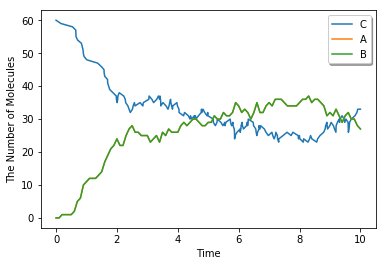

In [16]:
viz.plot_number_observer(obs1, obs2)

プロットのスタイルを設定したり、プロットに任意の関数を追加することもできます。


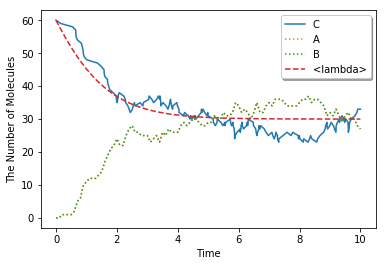

In [17]:
viz.plot_number_observer(obs1, '-', obs2, ':', lambda t: 60 * (1 + 2 * math.exp(-0.9 * t)) / (2 + math.exp(-0.9 * t)), '--')

位相平面でのプロットは、x軸とy軸を指定することによっても利用できます。


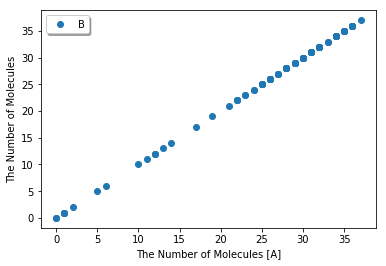

In [18]:
viz.plot_number_observer(obs2, 'o', x='A', y='B')

空間シミュレーションでは、`World`の状態を可視化するために、`viz.plot_world`が利用可能です。
この関数は、インタラクティブな方法で3次元ボリューム内のパーティクルの点をプロットします。
描画領域の右ボタンをクリックすると、画像を保存できます。


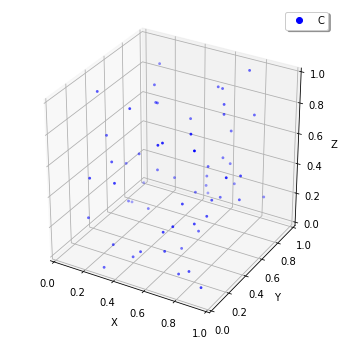

In [19]:
sim = create_simulator(spatiocyte.Factory(0.005))
# viz.plot_world(sim.world())
viz.plot_world(sim.world(), interactive=False)

`FixedIntervalHDF5Observer`として与えられた一連のHDF5ファイルからムービーを作ることもできます。

注： `viz.plot_movie`は、オプション`interactive=False`の時に追加ライブラリ `ffmpeg`を必要とします。


In [20]:
sim = create_simulator(spatiocyte.Factory(0.005))
obs1 = FixedIntervalHDF5Observer(0.02, 'test%02d.h5')
sim.run(1.0, obs1)
viz.plot_movie(obs1)

最後に、 `FixedIntervalTrajectoryObserver`に対応して、`viz.plot_trajectory`はパーティクル軌道の可視化を提供します。


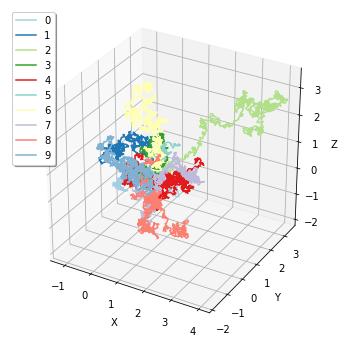

In [21]:
sim = create_simulator(spatiocyte.Factory(0.005))
obs1 = FixedIntervalTrajectoryObserver(1e-3)
sim.run(1, obs1)
# viz.plot_trajectory(obs1)
viz.plot_trajectory(obs1, interactive=False)